# 타이타닉호 생존자 예측

- RMS 타이타닉 호(이하 타이타닉 호)는 1912년 4월 15일 빙산과 충돌하여 침몰한 북대서양 횡단 여객선이다.

- 타이타닉 호에 탑승했던 승객들의 승객번호, 선실등급, 이름, 성별, 나이, 배우자, 형제자매, 부모, 자녀 수, 티켓번호, 운임요금, 선실명, 승선장 정보가 원인변수, 생존여부가 결과변수로 들어있는 데이터프레임을 다양한 기계학습 기법(KNN, 로지스틱회귀분석, 나이브베이즈, SVM, 의사결정나무, 랜덤포레스트)을 이용해 생존여부를 예측 모델을 구축하고자 한다.

## 1. 데이터 탐색

### 1. 모듈 장착

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family = 'Gulim')
import seaborn as sns
import os
import re

### 2. 디렉토리 설정

In [2]:
os.chdir('C:/Users/ssmoo/Desktop/kaggle_titanic_prediction')
data_path = 'C:/Users/ssmoo/Desktop/kaggle_titanic_prediction/data/'

### 3. 데이터 불러오기

In [3]:
raw_titanic = pd.read_csv(data_path + 'raw_data/train.csv')
titanic = raw_titanic.copy()

### 4. 데이터 확인

- PassengerId : 승객번호
- Survivied : 생존여부 -> 결과변수
- Pclass : 선실등급
- Name : 이름 -> 성, 직위 추출 가능
- Sex : 성별
- Age : 나이 -> 그룹화 가능, 결측값 수 : 177
- SibSp : 배우자, 형제자매 수
- Parch : 부모, 자녀 수
- Ticket : 티켓 번호 -> 여기서 특별한 정보를 찾기는 쉽지 않을것 같다.
- Fare : 운임 요금
- Cabin : 선실명 -> 필요없는 변수로 판단됨, 결측값 수 : 690
- Embarked : 승객이 배에 승선한곳, 결측값 수 : 2

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 5. 변수 탐색

각각의 변수가 생존여부에 영향을 어느정도 미치는지 데이터 시각화를 통해 탐색해본다.

#### 1.  Survived(생존여부)

In [24]:
titanic.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,position
Survived,,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549,549
1,342,342,342,342,290,342,342,342,342,136,340,342


- 사망자 수 : 549
- 생존자 수 : 342

Text(0.5, 1.0, '타이타닉호 사망/생존자 수 막대그래프')

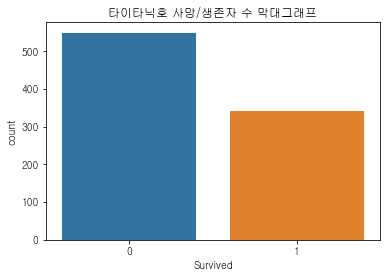

In [7]:
sns.countplot(data = titanic, x = 'Survived')
plt.title('타이타닉호 사망/생존자 수 막대그래프')

- 사망자 수가 생존자 수에 비해 많다
- 특성별 데이터 수가 불균형을 이루고 있으므로 ROC곡선을 통한 모델 적합도 평가가 필요하다.

#### 2. Pclass(선실등급) & Survived(생존여부)

In [8]:
titanic.groupby('Pclass').count()['PassengerId']

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64

- 1등급 : 216명
- 2등급 : 184명
- 3등급 : 491명

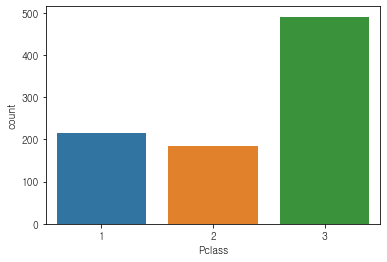

In [9]:
sns.countplot(data = titanic, x = 'Pclass')

In [10]:
titanic.groupby(['Pclass', 'Survived']).count()['PassengerId'].reset_index(['Pclass' , 'Survived']).pivot('Pclass', 'Survived', 'PassengerId')

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


- [1등급] 사망자 수 : 80, 생존자 수 : 136
- [2등급] 사망자 수 : 97, 생존자 수 : 87
- [3등급] 사망자 수 : 372, 생존자 수 : 119

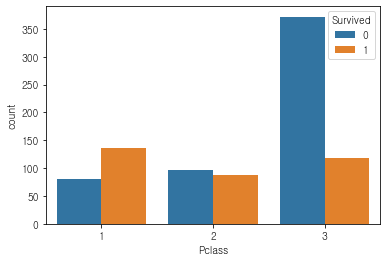

In [11]:
sns.countplot(data = titanic, x = 'Pclass', hue = 'Survived')

- 1등급에서 3등급으로 갈수록 사망 비율이 높아진 다는 것을 알 수 있다.

#### 3. Name(이름) vs Survived(생존여부)

In [13]:
# 포지션 뽑는 함수 생성
def find_position(string):
    position_compile = re.compile('[A-z]*\.')
    position = position_compile.findall(string)
    return position[0][:-1]


# 포지션 열 생성
titanic['position'] = titanic['Name'].apply(lambda x : find_position(x))

In [23]:
titanic.groupby('position').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
position,,,,,,,,,,,,
Capt,1,1,1,1,1,1,1,1,1,1,1,1
Col,2,2,2,2,2,2,2,2,2,2,1,2
Countess,1,1,1,1,1,1,1,1,1,1,1,1
Don,1,1,1,1,1,1,1,1,1,1,0,1
Dr,7,7,7,7,7,6,7,7,7,7,3,7
Jonkheer,1,1,1,1,1,1,1,1,1,1,0,1
Lady,1,1,1,1,1,1,1,1,1,1,1,1
Major,2,2,2,2,2,2,2,2,2,2,2,2
Master,40,40,40,40,40,36,40,40,40,40,7,40


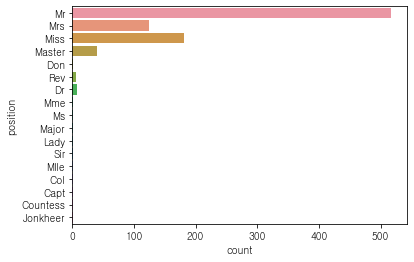

In [15]:
sns.countplot(data = titanic, y = 'position')

Master, Miss, Mr, Mrs의 포지션이 많은 것을 알 수 있다.
- 주 포지션을 Master, Miss, Mr, Mrs로 설정한다.

In [22]:
titanic.groupby(['position', 'Sex']).count()

PassengerId  Survived  Pclass  Name  Age  SibSp  Parch  \
position Sex                                                              
Capt     male              1         1       1     1    1      1      1   
Col      male              2         2       2     2    2      2      2   
Countess female            1         1       1     1    1      1      1   
Don      male              1         1       1     1    1      1      1   
Dr       female            1         1       1     1    1      1      1   
         male              6         6       6     6    5      6      6   
Jonkheer male              1         1       1     1    1      1      1   
Lady     female            1         1       1     1    1      1      1   
Major    male              2         2       2     2    2      2      2   
Master   male             40        40      40    40   36     40     40   
Miss     female          182       182     182   182  146    182    182   
Mlle     female            2         2       2     2    2      2      2   
Mme      female            1         1       1     1    1      1      1   
Mr       male            517       517     517   517  398    517    517   
Mrs      female          125       125     125   125  108    125    125   
Ms       female            1         1       1     1    1      1      1   
Rev      male              6         6       6     6    6      6      6   
Sir      male              1         1       1     1    1      1      1   

                 Ticket  Fare  Cabin  Embarked  
position Sex                                    
Capt     male         1     1      1         1  
Col      male         2     2      1         2  
Countess female       1     1      1         1  
Don      male         1     1      0         1  
Dr       female       1     1      1         1  
         male         6     6      2         6  
Jonkheer male         1     1      0         1  
Lady     female       1     1      1         1  
Major    male         2     2      2         2  
Master   male        40    40      7        40  
Miss     female     182   182     47       181  
Mlle     female       2     2      2         2  
Mme      female       1     1      1         1  
Mr       male       517   517     93       517  
Mrs      female     125   125     44       124  
Ms       female       1     1      0         1  
Rev      male         6     6      0         6  
Sir      male         1     1      1         1

- 주포지션을 제외하면 Dr 만 두 성별이 공존하고 나머지는 한가지 성별만 존재한다.
- 각각의 성별에 따라 Mr(남), Miss(여)로 설정.

#### 4. Sex(성별) vs Survived(생존여부)

In [21]:
titanic.groupby(['Sex', 'Survived']).count()

PassengerId  Pclass  Name  Age  SibSp  Parch  Ticket  Fare  \
Sex    Survived                                                               
female 0                  81      81    81   64     81     81      81    81   
       1                 233     233   233  197    233    233     233   233   
male   0                 468     468   468  360    468    468     468   468   
       1                 109     109   109   93    109    109     109   109   

                 Cabin  Embarked  position  
Sex    Survived                             
female 0             6        81        81  
       1            91       231       233  
male   0            62       468       468  
       1            45       109       109

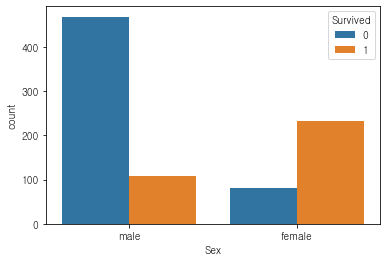

In [25]:
sns.countplot(data = titanic, x = 'Sex', hue = 'Survived')

남자는 생존비율이 매우 낮고 여자는 생존비율이 매우 높다.

#### 5.  Age(나이) vs Survived(생존여부)

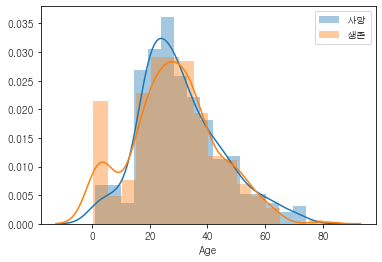

In [27]:
sns.distplot(titanic[(titanic['Survived'] == 0) & (titanic['Age'].notnull())].loc[:, 'Age'], label = '사망')
sns.distplot(titanic[(titanic['Survived'] == 1) & (titanic['Age'].notnull())].loc[:, 'Age'], label = '생존')
plt.legend()

- 생존자의 히스토그램에서 10세 미만 연령대의 생존자 수가 많다는 것을 확인할 수 있다.
- 사망자의 히스토그램에서 20세 이상 40세 미만의 연령대의 사망자 수가 많다는 것을 확인할 수 있다.

In [29]:
def get_aged(age):
    if age < 13:
        return 0
    elif age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 45:
        return 3
    elif age < 60:
        return 4
    elif age >= 60:
        return 5
    else:
        return age
    
titanic['aged'] = titanic['Age'].apply(lambda x : get_aged(x))

어린이(\~13, 0), 청소년(13\~20, 1), 청년(20\~30, 2), 장년(30\~45, 3), 중년(45\~60, 4), 노년(60\~, 5) 으로 구분하는 연령대 변수를 생성

In [30]:
titanic.groupby(['aged', 'Sex', 'Survived']).count()

PassengerId  Pclass  Name  Age  SibSp  Parch  Ticket  \
aged Sex    Survived                                                         
0.0  female 0                  13      13    13   13     13     13      13   
            1                  19      19    19   19     19     19      19   
     male   0                  16      16    16   16     16     16      16   
            1                  21      21    21   21     21     21      21   
1.0  female 0                   9       9     9    9      9      9       9   
            1                  34      34    34   34     34     34      34   
     male   0                  47      47    47   47     47     47      47   
            1                   5       5     5    5      5      5       5   
2.0  female 0                  20      20    20   20     20     20      20   
            1                  52      52    52   52     52     52      52   
     male   0                 123     123   123  123    123    123     123   
            1                  25      25    25   25     25     25      25   
3.0  female 0                  15      15    15   15     15     15      15   
            1                  63      63    63   63     63     63      63   
     male   0                 109     109   109  109    109    109     109   
            1                  28      28    28   28     28     28      28   
4.0  female 0                   7       7     7    7      7      7       7   
            1                  25      25    25   25     25     25      25   
     male   0                  46      46    46   46     46     46      46   
            1                  11      11    11   11     11     11      11   
5.0  female 1                   4       4     4    4      4      4       4   
     male   0                  19      19    19   19     19     19      19   
            1                   3       3     3    3      3      3       3   

                      Fare  Cabin  Embarked  position  
aged Sex    Survived                                   
0.0  female 0           13      2        13        13  
            1           19      2        19        19  
     male   0           16      0        16        16  
            1           21      7        21        21  
1.0  female 0            9      0         9         9  
            1           34     13        34        34  
     male   0           47      4        47        47  
            1            5      1         5         5  
2.0  female 0           20      2        20        20  
            1           52     19        52        52  
     male   0          123      7       123       123  
            1           25      8        25        25  
3.0  female 0           15      0        15        15  
            1           63     32        62        63  
     male   0          109     15       109       109  
            1           28     15        28        28  
4.0  female 0            7      2         7         7  
            1           25     15        25        25  
     male   0           46     20        46        46  
            1           11      8        11        11  
5.0  female 1            4      3         3         4  
     male   0           19      8        19        19  
            1            3      2         3         3

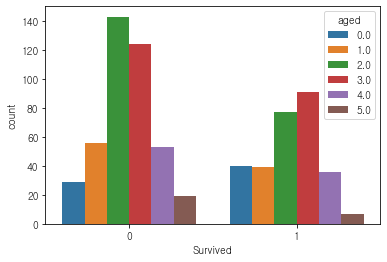

In [37]:
sns.countplot(data = titanic, x = 'Survived', hue = 'aged')

- 사망자(0)의 히스토그램을 보면 청,장년층의 사망자 수가 매우 높다는 것을 확인할 수 있다.
- 어린이(파란색)의 막대를 보면 생존자수가 사망자수에 비해 많다.

#### 6. SibSp(배우자, 형제자매 수) vs Survived(생존여부)

In [39]:
titanic.groupby(['SibSp', 'Survived']).count()

PassengerId  Pclass  Name  Sex  Age  Parch  Ticket  Fare  \
SibSp Survived                                                             
0     0                 398     398   398  398  296    398     398   398   
      1                 210     210   210  210  175    210     210   210   
1     0                  97      97    97   97   86     97      97    97   
      1                 112     112   112  112   97    112     112   112   
2     0                  15      15    15   15   14     15      15    15   
      1                  13      13    13   13   11     13      13    13   
3     0                  12      12    12   12    8     12      12    12   
      1                   4       4     4    4    4      4       4     4   
4     0                  15      15    15   15   15     15      15    15   
      1                   3       3     3    3    3      3       3     3   
5     0                   5       5     5    5    5      5       5     5   
8     0                   7       7     7    7    0      7       7     7   

                Cabin  Embarked  position  aged  
SibSp Survived                                   
0     0            49       398       398   296  
      1            77       208       210   175  
1     0            17        97        97    86  
      1            52       112       112    97  
2     0             1        15        15    14  
      1             5        13        13    11  
3     0             1        12        12     8  
      1             2         4         4     4  
4     0             0        15        15    15  
      1             0         3         3     3  
5     0             0         5         5     5  
8     0             0         7         7     0

배우자나 형제자매가 0명이거나 2명 이상일때는 1명있을때에 비해 사망 비율이 높다는것을 알 수 있다.

In [44]:
def get_SibSp_existence(SibSp):
    if SibSp == 1:
        return 1
    else:
        return 0

titanic['SibSp_existence'] = titanic['SibSp'].apply(lambda x : get_SibSp_existence(x))

In [45]:
titanic.groupby(['SibSp_existence', 'Survived']).count()

PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  \
SibSp_existence Survived                                                      
0               0                 452     452   452  452  338    452    452   
                1                 230     230   230  230  193    230    230   
1               0                  97      97    97   97   86     97     97   
                1                 112     112   112  112   97    112    112   

                          Ticket  Fare  Cabin  Embarked  position  aged  
SibSp_existence Survived                                                 
0               0            452   452     51       452       452   338  
                1            230   230     84       228       230   193  
1               0             97    97     17        97        97    86  
                1            112   112     52       112       112    97

#### 7. Parch(부모, 자녀 수) & Survived(생존여부)

In [46]:
titanic.groupby(['Parch', 'Survived']).count()

PassengerId  Pclass  Name  Sex  Age  SibSp  Ticket  Fare  \
Parch Survived                                                             
0     0                 445     445   445  445  335    445     445   445   
      1                 233     233   233  233  186    233     233   233   
1     0                  53      53    53   53   49     53      53    53   
      1                  65      65    65   65   61     65      65    65   
2     0                  40      40    40   40   29     40      40    40   
      1                  40      40    40   40   39     40      40    40   
3     0                   2       2     2    2    2      2       2     2   
      1                   3       3     3    3    3      3       3     3   
4     0                   4       4     4    4    4      4       4     4   
5     0                   4       4     4    4    4      4       4     4   
      1                   1       1     1    1    1      1       1     1   
6     0                   1       1     1    1    1      1       1     1   

                Cabin  Embarked  position  aged  SibSp_existence  
Parch Survived                                                    
0     0            50       445       445   335              445  
      1            91       231       233   186              233  
1     0            11        53        53    49               53  
      1            28        65        65    61               65  
2     0             6        40        40    29               40  
      1            17        40        40    39               40  
3     0             0         2         2     2                2  
      1             0         3         3     3                3  
4     0             1         4         4     4                4  
5     0             0         4         4     4                4  
      1             0         1         1     1                1  
6     0             0         1         1     1                1

부모 자녀 수가 0명일때는 1명 이상일때에 비해 사망자 비율이 높다.

In [47]:
# Parch -> Parch_existence (형제 자매의 유무 변수로 변경, 0 : 없다, 1 : 있다)
def get_Parch_existence(Parch):
    if Parch >= 1:
        return 1
    else:
        return Parch

titanic['Parch_existence'] = titanic['Parch'].apply(lambda x : get_Parch_existence(x))

In [48]:
titanic.groupby(['Parch_existence', 'Survived']).count()

PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  \
Parch_existence Survived                                                      
0               0                 445     445   445  445  335    445    445   
                1                 233     233   233  233  186    233    233   
1               0                 104     104   104  104   89    104    104   
                1                 109     109   109  109  104    109    109   

                          Ticket  Fare  Cabin  Embarked  position  aged  \
Parch_existence Survived                                                  
0               0            445   445     50       445       445   335   
                1            233   233     91       231       233   186   
1               0            104   104     18       104       104    89   
                1            109   109     45       109       109   104   

                          SibSp_existence  
Parch_existence Survived                   
0               0                     445  
                1                     233  
1               0                     104  
                1                     109

#### 8. Fare(운임요금) vs Survived(생존여부)

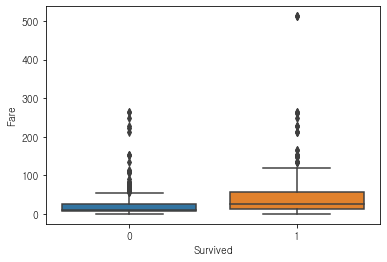

In [49]:
sns.boxplot(data = titanic, x = 'Survived', y = 'Fare')

생존자의 평균 운임 요금이 사망자의 평균 운임요금에 비해 높지만 t-검정을 이용해 통계적으로 유의한지 알아보자. 유의수준은 0.05로 둔다

In [51]:
from scipy import stats
stats.ttest_ind(titanic[titanic['Survived'] == 0]['Fare'], titanic[titanic['Survived'] == 1]['Fare'])

Ttest_indResult(statistic=-7.939191660871055, pvalue=6.120189341924198e-15)

p-value가 6.120189341924198e-15로 유의수준보다 낮아 통계적으로 유의하다는것을 확인할 수 있다.

#### 9. Embarked(승선장) vs Survived(생존여부)

In [53]:
titanic.groupby(['Embarked', 'Survived']).count()

PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  \
Embarked Survived                                                              
C        0                  75      75    75   75   51     75     75      75   
         1                  93      93    93   93   79     93     93      93   
Q        0                  47      47    47   47   20     47     47      47   
         1                  30      30    30   30    8     30     30      30   
S        0                 427     427   427  427  353    427    427     427   
         1                 217     217   217  217  201    217    217     217   

                   Fare  Cabin  position  aged  SibSp_existence  \
Embarked Survived                                                 
C        0           75     17        75    51               75   
         1           93     52        93    79               93   
Q        0           47      2        47    20               47   
         1           30      2        30     8               30   
S        0          427     49       427   353              427   
         1          217     80       217   201              217   

                   Parch_existence  
Embarked Survived                   
C        0                      75  
         1                      93  
Q        0                      47  
         1                      30  
S        0                     427  
         1                     217

C 와 Q 에서는 생존자 수와 사망자 수가 크게 차이나지 않지만 S에서는 많이 차이가 난다는 것을 확인 할 수 있다.

### 6. 탐색 결과

- Cabin을 제외한 모든 변수가 Survived(생존여부) 변수에 영향을 끼치는 것으로 보인다.
- Age(나이) -> Aged(연령대), Sibsp -> Sibsp_category, Parch -> Parch_existence로 범주화 한다.
- Fare(운임요금)이 유일하게 연속형 변수이며 이상치가 많이 확인되므로 Robust Scaling을 한다.
- Age변수의 결측값은 연속형변수이므로 Survived와 Age변수를 제외한 다른 변수들로 선형회귀를 이용하여 예측한다.